In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Constants
SEED = 256
CACHE_TTL = 5          # Cache TTL in seconds
CACHE_CAPACITY = 100   # Maximum number of objects the cache can hold
SIMULATION_TIME = 60   # Total time to run the simulation
EXPORT_NAME = "./export.csv"

ZIPF_CONSTANT = 2      # Shape parameter for the Zipf distribution (controls skewness)
MAX_REFRESH_RATE = 10


# Set random seeds
random.seed(SEED)
np.random.seed(SEED)

# Initialize simulation environment
env = simpy.Environment()

In [2]:
class Database:
    def __init__(self):
        # Each object now has a specific refresh rate 'mu'
        self.data = {i: f"Object {i}" for i in range(1, CACHE_CAPACITY + 1)}
        self.lambda_values = {i: np.random.zipf(ZIPF_CONSTANT) for i in range(1, CACHE_CAPACITY + 1)}  # Request rate 'lambda' for each object
        self.mu_values = {i: random.uniform(1, MAX_REFRESH_RATE) for i in range(1, CACHE_CAPACITY + 1)}  # Refresh rate 'mu' for each object
        self.next_request = {i: np.random.exponential(self.lambda_values[i]) for i in range(1, CACHE_CAPACITY + 1)}


    def get_object(self, obj_id):
        print(f"[{env.now:.2f}] Database: Fetched {self.data.get(obj_id, 'Unknown')} for ID {obj_id}")
        return self.data.get(obj_id, None)

In [3]:
class Cache:
    def __init__(self, env, db):
        self.env = env
        self.db = db
        self.storage = {}  # Dictionary to store cached objects
        self.ttl = {}      # Dictionary to store TTLs
        self.age = {}      # Dictionary to store age of each object
        self.cache_size_over_time = []  # To record cache state at each interval
        self.cache_next_request_over_time = []
        self.request_log = {i: [] for i in range(1, CACHE_CAPACITY + 1)}
        self.hits = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track hits per object
        self.misses = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track misses per object
        self.cumulative_age = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track cumulative age per object
        self.access_count = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track access count per object
        self.next_refresh = {}  # Track the next refresh time for each cached object
        
    def get(self, obj_id):
        if obj_id in self.storage and self.ttl[obj_id] > env.now:
            # Cache hit: increment hit count and update cumulative age
            self.hits[obj_id] += 1
            self.cumulative_age[obj_id] += self.age[obj_id]
            self.access_count[obj_id] += 1
        else:
            # Cache miss: increment miss count
            self.misses[obj_id] += 1
            self.access_count[obj_id] += 1
            
            # Fetch the object from the database if it’s not in cache
            obj = self.db.get_object(obj_id)
            
            # If the cache is full, evict the oldest object
            if len(self.storage) >= CACHE_CAPACITY:
                self.evict_oldest()
            
            # Add the object to cache, set TTL, reset age, and schedule next refresh
            self.storage[obj_id] = obj
            self.ttl[obj_id] = env.now + CACHE_TTL
            self.age[obj_id] = 0
            self.next_refresh[obj_id] = env.now + np.random.exponential(self.db.mu_values[obj_id])  # Schedule refresh

        
    def evict_oldest(self):
        """Remove the oldest item from the cache to make space."""
        oldest_id = max(self.age, key=self.age.get)  # Find the oldest item by age
        print(f"[{env.now:.2f}] Cache: Evicting object {oldest_id} to make space")
        del self.storage[oldest_id]
        del self.ttl[oldest_id]
        del self.age[oldest_id]
        
    def refresh_object(self, obj_id):
        """Refresh the object from the database to keep it up-to-date."""
        obj = self.db.get_object(obj_id)
        self.storage[obj_id] = obj
        self.ttl[obj_id] = env.now + CACHE_TTL
        self.age[obj_id] = 0
        print(f"[{env.now:.2f}] Cache: Refreshed object {obj_id}")
        
    def age_objects(self):
        """Increment age of each cached object."""
        for obj_id in list(self.age.keys()):
            if self.ttl[obj_id] > env.now:
                self.age[obj_id] += 1
                print(f"[{env.now:.2f}] Cache: Object {obj_id} aged to {self.age[obj_id]}")
            else:
                # Remove object if its TTL expired
                print(f"[{env.now:.2f}] Cache: Object {obj_id} expired")
                del self.storage[obj_id]
                del self.ttl[obj_id]
                del self.age[obj_id]
                
    def record_cache_state(self):
        """Record the current cache state (number of objects in cache) over time."""
        self.cache_size_over_time.append((env.now, len(self.storage)))
        self.cache_next_request_over_time.append((env.now, self.db.next_request.copy()))

In [4]:
def age_cache_process(env, cache):
    """Process that ages cache objects over time, removes expired items, and refreshes based on object-specific intervals."""
    while True:
        cache.age_objects()  # Age objects and remove expired ones

        # Refresh objects based on their individual refresh intervals
        for obj_id in list(cache.storage.keys()):
            # Check if it's time to refresh this object based on next_refresh
            if env.now >= cache.next_refresh[obj_id]:
                cache.refresh_object(obj_id)
                # Schedule the next refresh based on the object's mu
                cache.next_refresh[obj_id] = env.now + np.random.exponential(cache.db.mu_values[obj_id])
        
        cache.record_cache_state()  # Record cache state at each time step
        yield env.timeout(1)  # Run every second


In [5]:
def client_request_process(env, cache):
    """Client process that makes requests for objects from the cache."""
    while True:
        obj_id, next_request = min(cache.db.next_request.items(), key=lambda x: x[1])
        yield env.timeout(next_request - env.now)
        if env.now >= next_request:
            print(f"[{env.now:.2f}] Client: Requesting object {obj_id}")
            cache.get(obj_id)
            
            print(f"[{env.now:.2f}] Client: Schedule next request for {obj_id}")
            next_request = env.now + np.random.exponential(cache.db.lambda_values[obj_id])
            cache.request_log[obj_id].append(next_request)
            cache.db.next_request[obj_id] = next_request


In [6]:
# Instantiate components
db = Database()
cache = Cache(env, db)

In [7]:
# Start processes
env.process(age_cache_process(env, cache))
env.process(client_request_process(env, cache))

# Run the simulation
env.run(until=SIMULATION_TIME)

[0.03] Client: Requesting object 52
[0.03] Database: Fetched Object 52 for ID 52
[0.03] Client: Schedule next request for 52
[0.05] Client: Requesting object 75
[0.05] Database: Fetched Object 75 for ID 75
[0.05] Client: Schedule next request for 75
[0.06] Client: Requesting object 20
[0.06] Database: Fetched Object 20 for ID 20
[0.06] Client: Schedule next request for 20
[0.08] Client: Requesting object 99
[0.08] Database: Fetched Object 99 for ID 99
[0.08] Client: Schedule next request for 99
[0.08] Client: Requesting object 65
[0.08] Database: Fetched Object 65 for ID 65
[0.08] Client: Schedule next request for 65
[0.09] Client: Requesting object 14
[0.09] Database: Fetched Object 14 for ID 14
[0.09] Client: Schedule next request for 14
[0.13] Client: Requesting object 55
[0.13] Database: Fetched Object 55 for ID 55
[0.13] Client: Schedule next request for 55
[0.15] Client: Requesting object 4
[0.15] Database: Fetched Object 4 for ID 4
[0.15] Client: Schedule next request for 4
[0.1

In [8]:
# Calculate and print hit rate and average age for each object
for obj_id in range(1, CACHE_CAPACITY + 1):
    if cache.access_count[obj_id] != 0:
        hit_rate = cache.hits[obj_id] / max(1, cache.access_count[obj_id])  # Avoid division by zero
        avg_age = cache.cumulative_age[obj_id] / max(1, cache.hits[obj_id])  # Only average over hits
        print(f"Object {obj_id}: Hit Rate = {hit_rate:.2f}, Average Age = {avg_age:.2f}")

Object 1: Hit Rate = 0.90, Average Age = 1.75
Object 2: Hit Rate = 0.91, Average Age = 1.82
Object 3: Hit Rate = 0.87, Average Age = 1.58
Object 4: Hit Rate = 0.94, Average Age = 0.69
Object 5: Hit Rate = 0.40, Average Age = 2.00
Object 6: Hit Rate = 0.94, Average Age = 1.19
Object 7: Hit Rate = 0.81, Average Age = 1.92
Object 8: Hit Rate = 0.67, Average Age = 1.75
Object 9: Hit Rate = 0.92, Average Age = 1.56
Object 10: Hit Rate = 0.89, Average Age = 1.65
Object 11: Hit Rate = 0.78, Average Age = 1.62
Object 12: Hit Rate = 0.94, Average Age = 1.16
Object 13: Hit Rate = 0.84, Average Age = 2.43
Object 14: Hit Rate = 0.92, Average Age = 1.36
Object 15: Hit Rate = 0.79, Average Age = 1.52
Object 16: Hit Rate = 0.60, Average Age = 1.33
Object 17: Hit Rate = 0.38, Average Age = 2.33
Object 18: Hit Rate = 0.67, Average Age = 2.10
Object 19: Hit Rate = 0.78, Average Age = 2.04
Object 20: Hit Rate = 0.91, Average Age = 1.53
Object 21: Hit Rate = 0.81, Average Age = 1.91
Object 22: Hit Rate = 

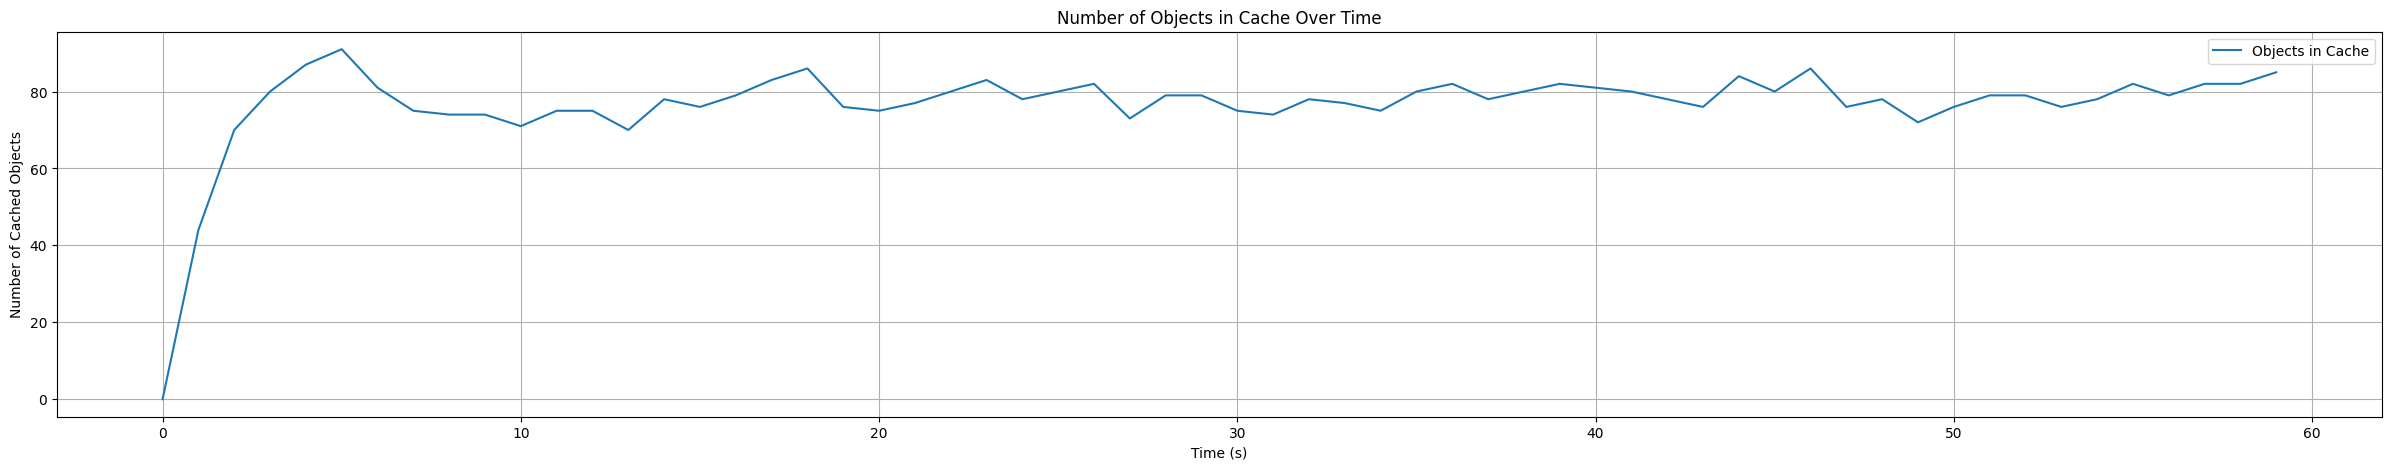

In [9]:
# Extract recorded data for plotting
times, cache_sizes = zip(*cache.cache_size_over_time)

# Plot the cache size over time
plt.figure(figsize=(30, 5))
plt.plot(times, cache_sizes, label="Objects in Cache")
plt.xlabel("Time (s)")
plt.ylabel("Number of Cached Objects")
plt.title("Number of Objects in Cache Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
access_count = pd.DataFrame.from_dict(cache.access_count, orient='index', columns=['access_count'])
hits = pd.DataFrame.from_dict(cache.hits, orient='index', columns=['hits'])
misses = pd.DataFrame.from_dict(cache.misses, orient='index', columns=['misses'])
mu = pd.DataFrame.from_dict(db.mu_values, orient='index', columns=['mu'])
lmbda = pd.DataFrame.from_dict(db.lambda_values, orient='index', columns=['lambda'])
hit_rate = pd.DataFrame(np.round((hits.to_numpy()/access_count.to_numpy())*100,2), columns=['hit_rate'])

In [11]:
merged = access_count.merge(hits, left_index=True, right_index=True).merge(misses, left_index=True, right_index=True)\
    .merge(mu, left_index=True, right_index=True).merge(lmbda, left_index=True, right_index=True)\
    .merge(hit_rate, left_index=True, right_index=True)
merged.to_csv(EXPORT_NAME)
merged

access_count  hits  misses        mu  lambda  hit_rate
1             63    57       6  5.399654       1     90.91
2             66    60       6  4.890336       1     86.54
3             52    45       7  4.375445       1     93.75
4             48    45       3  1.358966       1     40.00
5             10     4       6  7.946780       5     93.90
..           ...   ...     ...       ...     ...       ...
95            53    46       7  4.079818       1     90.77
96            65    59       6  7.308755       1     77.42
97            31    24       7  3.078773       2     98.15
98            54    53       1  1.515769       1     86.67
99            45    39       6  4.257416       1     28.57

[99 rows x 6 columns]

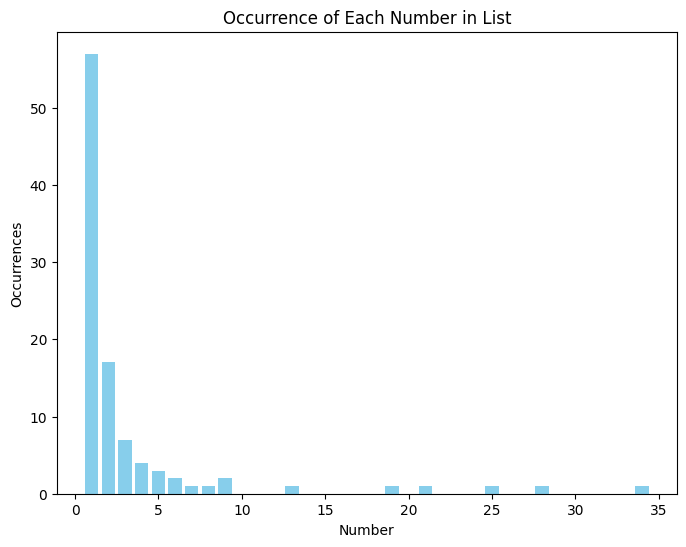

In [12]:
from collections import Counter
# Count occurrences of each number
count = Counter(list(db.lambda_values.values()))

# Separate the counts into two lists for plotting
x = list(count.keys())  # List of unique numbers
y = list(count.values())  # List of their respective counts

# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(x, y, color='skyblue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Occurrences')
plt.title('Occurrence of Each Number in List')

# Show the plot
plt.show()